In [ ]:
# hide
# all_slow

# Segmentation ResNet18-UNET from Kaggle

> Pytorch solution from Kaggle.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/15_torch.seg_unet_resnet18.ipynb)

This notebook uses a UNet model with pretrained resnet18 encoder, with simple augmentations using albumentations library, uses BCE loss, metrics like Dice and IoU. The segmentation model is from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) which comes with a lot pre-implemented segmentation architectures. 

The kaggle kernel from which I've borrowed this code is: https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.all import *

In [ ]:
from matplotlib import pyplot as plt

import warnings
import random
import os
import pandas as pd
import numpy as np
import torch
import torch.backends.cudnn as cudnn

import segmentation_models_pytorch as smp

seed_everything(69)

In [ ]:
torch.device("cuda:0").type

'cuda'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri Mar 26 12:38:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   24C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = smp.Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)

In [ ]:
#model

## Training

In [ ]:
model_trainer = Trainer(model, num_epochs=20, save_path=models_dir/"kaggle-UNET-ResNet34.pth", bs=16)

In [ ]:
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 10:21:58
Loss: 0.0915 | IoU: 0.0398 | dice: 0.4091 | dice_neg: 0.8044 | dice_pos: 0.0550
Starting epoch: 0 | phase: val | ⏰: 10:38:10
Loss: 0.0284 | IoU: 0.2677 | dice: 0.6111 | dice_neg: 0.9141 | dice_pos: 0.3548
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 10:40:34
Loss: 0.0230 | IoU: 0.2976 | dice: 0.5621 | dice_neg: 0.7621 | dice_pos: 0.3830
Starting epoch: 1 | phase: val | ⏰: 10:56:47
Loss: 0.0190 | IoU: 0.2983 | dice: 0.6070 | dice_neg: 0.8715 | dice_pos: 0.3833
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 10:59:04
Loss: 0.0182 | IoU: 0.3224 | dice: 0.6120 | dice_neg: 0.8406 | dice_pos: 0.4073
Starting epoch: 2 | phase: val | ⏰: 11:15:15
Loss: 0.0170 | IoU: 0.3423 | dice: 0.6571 | dice_neg: 0.9314 | dice_pos: 0.4252
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 11:17:38
Loss: 0.0161 | IoU: 0.3467 | dice: 0.6172 | 

In [ ]:
loaded_dict = torch.load(models_dir/"kaggle-UNET-ResNet34.pth")
model.load_state_dict(loaded_dict["state_dict"], strict=True)

<All keys matched successfully>

In [ ]:
model_trainer = Trainer(model, num_epochs=10, save_path=models_dir/"kaggle-UNET-ResNet34-stage2.pth", bs=16)

In [ ]:
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 20:27:36
Loss: 0.0101 | IoU: 0.4904 | dice: 0.7336 | dice_neg: 0.8758 | dice_pos: 0.6063
Starting epoch: 0 | phase: val | ⏰: 20:45:09
Loss: 0.0110 | IoU: 0.4701 | dice: 0.7416 | dice_neg: 0.9349 | dice_pos: 0.5781
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 20:47:55
Loss: 0.0098 | IoU: 0.4981 | dice: 0.7364 | dice_neg: 0.8752 | dice_pos: 0.6121
Starting epoch: 1 | phase: val | ⏰: 21:05:03
Loss: 0.0122 | IoU: 0.4473 | dice: 0.7252 | dice_neg: 0.9253 | dice_pos: 0.5560

Starting epoch: 2 | phase: train | ⏰: 21:07:26
Loss: 0.0098 | IoU: 0.5038 | dice: 0.7479 | dice_neg: 0.8926 | dice_pos: 0.6184
Starting epoch: 2 | phase: val | ⏰: 21:24:05


In [ ]:
loaded_dict = torch.load(models_dir/"kaggle-UNET-ResNet34-stage2.pth")
model.load_state_dict(loaded_dict["state_dict"], strict=True)

<All keys matched successfully>

## Results

In [ ]:
loaded_dict["best_loss"]

0.010313277598574392

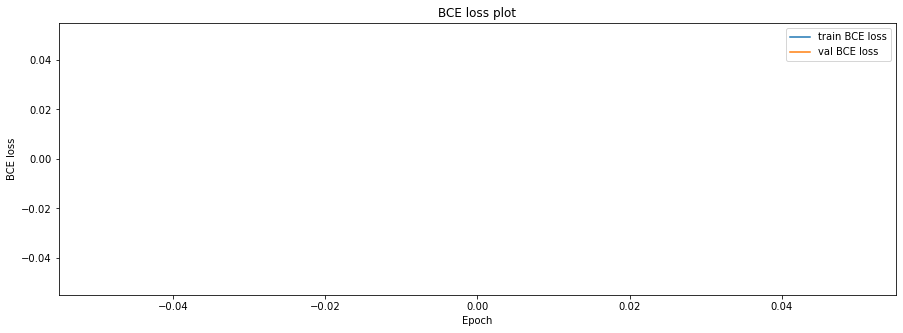

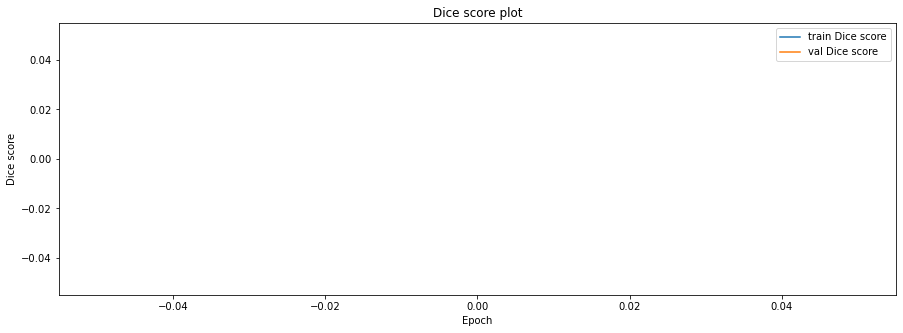

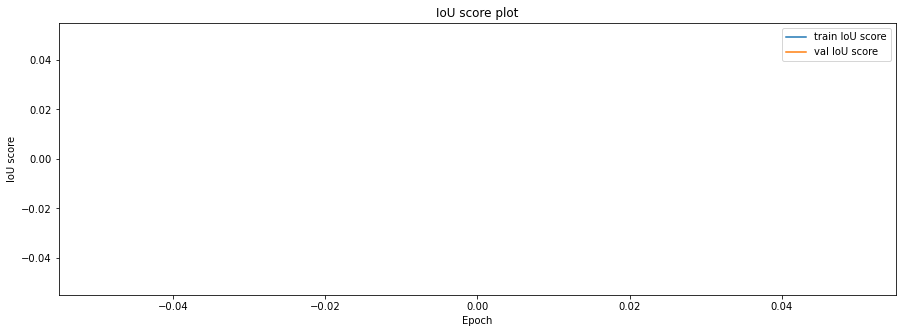

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores  # overall dice
iou_scores = model_trainer.iou_scores


def plot(scores, name):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(scores["train"])),
             scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot')
    plt.xlabel('Epoch')
    plt.ylabel(f'{name}')
    plt.legend()
    plt.show()


plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Inference

In [ ]:
testset_dl = get_test_dls()

In [ ]:
pred = Predict(test_dl=testset_dl, model=model)

In [ ]:
threshold = 0.5
min_size = 3000
df_preds = pred(threshold=threshold, min_size=min_size)

100%|██████████| 1377/1377 [03:09<00:00,  7.27it/s]


In [ ]:
df_preds.head()

,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,146438 31 146477 151 146640 47 146692 252 146947 254 147203 254 147459 254 147714 255 147970 255 148226 255 148482 255 148738 255 148994 255 149250 255 149506 255 149762 255 150018 255 150274 255 150530 255 150786 255 151043 254 151299 254 151555 254 151812 253 152078 55 152155 165 152433 30 152494 18 152551 24
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,


In [ ]:
pred.save_submission("pytorch-resnet34-unet")

## Fastai interface - failed

In [ ]:
from fastai.callback.data import CudaCallback
from fastai.callback.progress import CSVLogger, ShowGraphCallback
from fastai.callback.training import GradientAccumulation
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.optimizer import OptimWrapper
from fastai.losses import BCEWithLogitsLossFlat

In [ ]:
def opt_func(params, lr=4e-5, *args, **kwargs):
    """Basic optimizer wrapper function"""
    return OptimWrapper(torch.optim.Adam(params, lr=lr), *args, **kwargs)

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
bs = 16

In [ ]:
train_dls = get_train_dls(phase="train", batch_size=bs, num_workers=6)
valid_dls = get_train_dls(phase="val", batch_size=bs, num_workers=6)

In [ ]:
dls = DataLoaders(train_dls, valid_dls)

In [ ]:
cbs = [
    CudaCallback(),
    ShowGraphCallback(),
    ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
    GradientAccumulation(n_acc=32),
]

In [ ]:
learn = Learner(
    dls, 
    model, 
    loss_func=loss_fn, 
    opt_func=opt_func, 
    cbs=cbs, 
    metrics=ModDiceMulti,
    model_dir=models_dir
).to_fp16() 

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.02290867641568184)

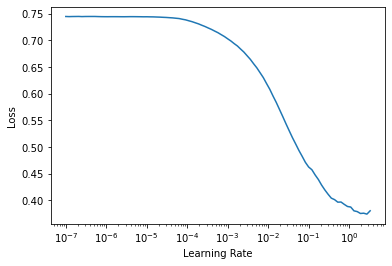

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mod_dice_multi,time
0,0.042382,0.045435,0.193304,11:21
1,0.039707,0.039049,0.016201,11:12
2,0.036921,0.045955,0.012907,11:12
3,0.036207,0.038575,0.012907,11:20
4,0.034925,0.037461,0.012907,11:11
5,0.033913,0.036488,0.012908,11:11
6,0.034146,0.038180,0.014261,11:11
7,0.033293,0.038036,0.013019,11:11
8,0.033435,0.040121,0.012907,11:11
9,0.031402,0.033164,0.012907,11:13


Better model found at epoch 0 with valid_loss value: 0.04543525353074074.


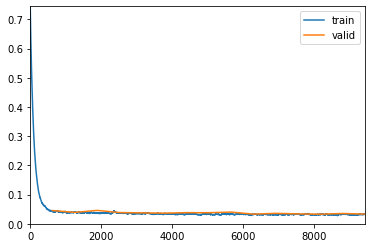

Better model found at epoch 1 with valid_loss value: 0.03904934227466583.
Better model found at epoch 3 with valid_loss value: 0.038575224578380585.
Better model found at epoch 4 with valid_loss value: 0.03746073320508003.
Better model found at epoch 5 with valid_loss value: 0.03648819029331207.
Better model found at epoch 9 with valid_loss value: 0.03316431865096092.
Better model found at epoch 12 with valid_loss value: 0.032977741211652756.


In [ ]:
fit_cb = [SaveModelCallback(fname="fastai-UNET-ResNet34-smp-pytorch_dls-stage1"),
         CSVLogger(fname="fastai-UNET-ResNet34-training-log.csv")]
learn.fit(15, lr=5e-4, cbs=fit_cb, wd=0.01)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=6.309573450380412e-07)

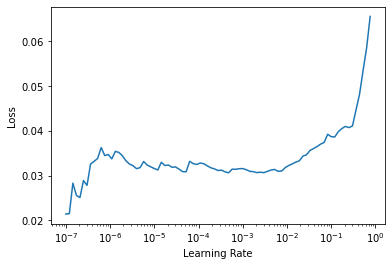

In [ ]:
learn.lr_find()

In [ ]:
learn.metrics = [dice, iou]

In [ ]:
learn.validate()

(#3) [0.03297774866223335,0.11617868393659592,0.06246330961585045]